# Pre-trained model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34905.jpg  
  inflating: real_v

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6581864455017358815
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14156786785028128616
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [5]:
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [6]:
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100

In [7]:
generator = load_model("/content/models/generator.keras")

generator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
# Generating the fake images training data from the generator
def save_fake(output_dir,num_images=1000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    generated_images = generator.predict(tf.random.normal((num_images, latent_features, 1)),verbose=0)

    for i in range(num_images):
        image = generated_images[i]
        image = (image + 1) / 2
        image_path = os.path.join(output_dir, f"{i}.jpg")
        tf.keras.preprocessing.image.save_img(image_path, image)

    print(f"{i + 1} images generated and saved to {output_dir}.")

save_fake("/content/resnet_data/train/0",num_images=25000)
save_fake("/content/resnet_data/valid/0",num_images=5000)
save_fake("/content/resnet_data/test/0",num_images=10000)

25000 images generated and saved to /content/resnet_data/train/0.
5000 images generated and saved to /content/resnet_data/valid/0.
10000 images generated and saved to /content/resnet_data/test/0.


In [11]:
# Saving the real images in a different directory
def save_real(source_dir, destination_dir, num_images=1000):
    real_folder = os.path.join(source_dir, 'real')
    image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)]

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    image_counter = 0
    for i, file_path in enumerate(image_paths):
        with Image.open(file_path) as img:
            output_path = os.path.join(destination_dir, f"{i}.jpg")
            img.save(output_path)
            image_counter += 1
        if image_counter >= num_images:
                break
    print(f"{num_images} images saved from {source_dir}to {destination_dir}.")

save_real('/content/real_vs_fake/real-vs-fake/train', "resnet_data/train/1", num_images=25000)
save_real('/content/real_vs_fake/real-vs-fake/valid', "resnet_data/valid/1", num_images=5000)
save_real('/content/real_vs_fake/real-vs-fake/test', "resnet_data/test/1", num_images=10000)

25000 images saved from /content/real_vs_fake/real-vs-fake/trainto resnet_data/train/1.
5000 images saved from /content/real_vs_fake/real-vs-fake/validto resnet_data/valid/1.
10000 images saved from /content/real_vs_fake/real-vs-fake/testto resnet_data/test/1.


In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/resnet_data/train",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 50000 files belonging to 2 classes.


In [13]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/resnet_data/valid",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 10000 files belonging to 2 classes.


In [14]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/resnet_data/test",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=69,
)

Found 20000 files belonging to 2 classes.


In [15]:
def augument(x, y):
    img = tf.cast(x, tf.float32)
    img = (img - 127.5) / 127.5
    return img, y

In [16]:
train_dataset = train_dataset.map(augument)
valid_dataset = valid_dataset.map(augument)
test_dataset = test_dataset.map(augument)

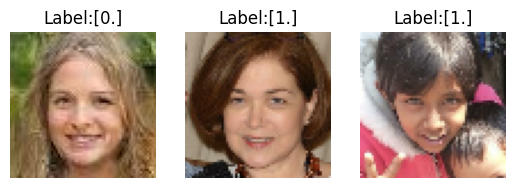

In [18]:
for batch, labels in train_dataset.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

## Convolutional neural network

In [19]:
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet_clf = Model(inputs=base_model.input, outputs=predictions)
resnet_clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0][0]']   

In [24]:
save_callback = ModelCheckpoint('/content/gdrive/MyDrive/GAN_research/resnet_clf_cp.h5'
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)

resnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])

In [25]:
tf.keras.backend.clear_session()
resnet_clf_history = resnet_clf.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[save_callback],
    use_multiprocessing=True
)

Epoch 1/500
196/196 [==============================] - 78s 218ms/step - loss: 0.0184 - accuracy: 0.9920 - val_loss: 82.5355 - val_accuracy: 0.5000
Epoch 2/500
196/196 [==============================] - 41s 207ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 13.4254 - val_accuracy: 0.5000
Epoch 3/500
196/196 [==============================] - 42s 209ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 10.4405 - val_accuracy: 0.5000
Epoch 4/500
196/196 [==============================] - 42s 214ms/step - loss: 6.2149e-04 - accuracy: 0.9998 - val_loss: 10.0921 - val_accuracy: 0.5000
Epoch 5/500
196/196 [==============================] - 43s 216ms/step - loss: 3.0864e-05 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9981
Epoch 6/500
196/196 [==============================] - 41s 207ms/step - loss: 9.4536e-06 - accuracy: 1.0000 - val_loss: 1.1236e-07 - val_accuracy: 1.0000
Epoch 7/500
196/196 [==============================] - 38s 193ms/step - loss: 6.7557e-04 - accuracy: 0.9

KeyboardInterrupt: 

In [ ]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
best_model = load_model("models/resnet_clf_cp.h5")
test_loss, test_accuracy = best_model.evaluate(test_dataset, verbose=0)
print(f"Test loss:{test_loss}")
print(f"Test accuracy:{test_accuracy}")

Manual testing

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
def manual_prediction(img_path, model):
  img = image.load_img(img_path, target_size=(image_height, image_width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Normalize pixel values to be between 0 and 1
  img_array /= 255.0

  # Make predictions
  prediction = model.predict(preprocess_input(img_array))

  plt.imshow(img)
  plt.title(f"Label:{prediction[0][0]}")

In [ ]:
manual_prediction("manual_test_images/Hard.jpeg",best_model)

In [ ]:
manual_prediction("manual_test_images/Medium.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Easy.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Real.jpg",best_model)